In [1]:
import sys
sys.path.insert(0, '..')

import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
import matplotlib.pyplot as plt
import measure_metric.measureMetric as measureMetric

from stencilgen.stencil import *
from tsmgen.kernel import *
import stencilgen.bench as stencilbench
import tsmgen.benchmark as tsmbench
from predict import *

In [2]:
%load_ext autoreload
%autoreload 1
%aimport stencilgen.stencil
%aimport stencilgen.bench
%aimport predict

# Goal


                                         launch config
                                           |
                                           v             
    Generator -> Perf Characteristics -> Prediction  
        |
        v
      Code
  
  
- Predict performance from a few code characteristics that any code generator can generate alongside the code
- No look at the actual code, no attempt to derive data from code
- Limitation to kernels:
    - no (complex) control flow
    - no indirect accesses
- Perf characteristics:
    - load/stores with expression for the address dependent only on thread ID
    - number of FP operations
    - (dependence of FP ops)
    - (# of Int operations)
- Launch config: 
    - block size
    - grid size

## Exmaples for Generators: stencils and TSMs

In [4]:
kernel =  Kernel2DBoxStencil(stencil_range = 1, l1only=True, singleTid=True)

In [5]:
print( kernel.text)

void __global__  Kernel2DStencil (double* A, double* B, int w, int h) {
  int x = (threadIdx.x + blockIdx.x * blockDim.x) % 128 + 1024;
  int y = (threadIdx.y + blockIdx.y * blockDim.y) % 64 + 1024;
  x = 1024;
  y = 1024;
  double sum = (
                B[(y + -1) * w + x + -1] + 
                B[(y + -1) * w + x + 0] + 
                B[(y + -1) * w + x + 1] + 
                B[(y + 0) * w + x + -1] + 
                B[(y + 0) * w + x + 0] + 
                B[(y + 0) * w + x + 1] + 
                B[(y + 1) * w + x + -1] + 
                B[(y + 1) * w + x + 0] + 
                B[(y + 1) * w + x + 1] ) * 2.34;
  if(threadIdx.x > 123123 + sum)   A[y * w + x] = sum;
    }



In [6]:
stencilbench.printSASS(kernel.text)

241
	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_64BIT_ADDRESS EF_CUDA_SM70 EF_CUDA_VIRTUAL_SM(EF_CUDA_SM70)"
	.elftype	@"ET_EXEC"


//--------------------- .debug_frame              --------------------------
	.section	.debug_frame,"",@progbits
.debug_frame:
        /*0000*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff
        /*0010*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x03, 0x00, 0x04, 0x7c, 0xff, 0xff, 0xff, 0xff, 0x0f, 0x0c, 0x81, 0x80
        /*0020*/ 	.byte	0x80, 0x28, 0x00, 0x08, 0xff, 0x81, 0x80, 0x28, 0x08, 0x81, 0x80, 0x80, 0x28, 0x00, 0x00, 0x00
        /*0030*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x30, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0040*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0048*/ 	.dword	Kernel2DStencil
        /*0050*/ 	.byte	0xf0, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x02, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00
        /*0060*/ 	.byte	0x00, 

In [9]:
tsmkernel = Kernel(64, 64, 2, 2, 128, dtype="double", transposed=True, leapFrog=False)
print(tsmkernel.text)

#include <cuComplex.h>


__device__ inline double daxpy(double val, double val2, double val3)
{
    return val+val2*val3;
}


__device__ inline cuFloatComplex caxpy(cuFloatComplex val, cuFloatComplex val2, cuFloatComplex val3)
{
    return cuCaddf(val,cuCmulf(val2,val3));
}


__device__ inline cuDoubleComplex zaxpy(cuDoubleComplex val, cuDoubleComplex val2, cuDoubleComplex val3)
{
    double real = val.x + - val2.y*val3.y + val2.x*val3.x;
    double imag = val.y + val2.y*val3.x + val2.x*val3.y;

    return make_cuDoubleComplex(real, imag);
}

__device__ inline cuDoubleComplex atomicAdd(cuDoubleComplex* address, cuDoubleComplex val) {
    double* dadd = reinterpret_cast<double*>(address);
    return make_cuDoubleComplex(atomicAdd(dadd, val.x), atomicAdd(dadd + 1, val.y));
}


__device__ inline  double VALUE(double v) {  return v;}

void __global__ __launch_bounds__(128, 2) tsmttsm_64_64_2_2 (double* A, double* B, double* C, int64_t K) {
  int tidx = threadIdx.x + blockIdx.x*blockDim.x;


In [10]:
tsmbench.printSASS(tsmkernel.text)

304
	.headerflags	@"EF_CUDA_TEXMODE_UNIFIED EF_CUDA_64BIT_ADDRESS EF_CUDA_SM70 EF_CUDA_VIRTUAL_SM(EF_CUDA_SM70)"
	.elftype	@"ET_EXEC"


//--------------------- .debug_frame              --------------------------
	.section	.debug_frame,"",@progbits
.debug_frame:
        /*0000*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff
        /*0010*/ 	.byte	0xff, 0xff, 0xff, 0xff, 0x03, 0x00, 0x04, 0x7c, 0xff, 0xff, 0xff, 0xff, 0x0f, 0x0c, 0x81, 0x80
        /*0020*/ 	.byte	0x80, 0x28, 0x00, 0x08, 0xff, 0x81, 0x80, 0x28, 0x08, 0x81, 0x80, 0x80, 0x28, 0x00, 0x00, 0x00
        /*0030*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0xff, 0xff, 0xff, 0xff, 0x30, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0040*/ 	.byte	0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00
        /*0048*/ 	.dword	tsmttsm_64_64_2_2
        /*0050*/ 	.byte	0xf0, 0x05, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x04, 0x02, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00
        /*0060*/ 	.byte	0x00

## Phase Model

 - Compiled kernels usually have a typical structure with distinct phases:
  
       INT
       LD 
       FP 
       ST (optional)
       jb/exit 
   
 - INT ususally contains address calculations
 - All LD instructions are moved to the front of the loop/program for maximum overlap of memory latencies
 - Phases may overlap by some amount for larger kernels, to save on registers  
 

## Execution phases

    -                      -
    | (Tint)               |
    -      –               |
    |      |               |
    | Tld  |               |
    |      |               |
    –      | Tlat          |
           |               |
           |               |
           |               | Ttotal
       -   -  –            |
       |      |            |
       |      |            |
       | Tfp  | Tl1_thru   |
       |      |            |
       |      -            |
       –                   -
       
 - INT execution is difficult for the generator to generate, and difficult to predict, because various rates/latencies and usually some overlap with LD phase. Necessary for precise L1 bound predictions though. Small impact for memory bound cases, so usually omitted
 
 - LD execution phase: time taken to just enqueue the loads. Executed at a constant 1/4cyc throughput, regardless of cache hit/miss. Similar to INT execution: sometimes coissued with FP, overlaps with memory latency. Necessary for precise L1 bound predictions, where latency is short. Can be omitted otherwise

 - Tlat = Tlat_mem + Tlat_L2 = (271 + 200) cyc

 - FP (DP) execution phase: 1/4 throughput, 8cyc latency. 
 - L1 thru: Four 32B L1 cache lines per cycle

 - Assumption: the very first load instruction is a cache miss and loads from memory. All other cache misses hide behind that latency and are considered L1 cache hits. Tlatency therefore overlaps with Tld.
 
 - The FP phase can start as soon as the first load has returned, after Tlat. The L1 cache can now also start the outstanding load delievery phase Tl1_thru, depending on L1 bandwidth. Overlaps with DP phase (not quite perfectly sometimes)


 - Single warp execution time: Ttotal = Tint + max(Tld, Tlat) + max(Tfp, Tl1_thru) 
 

## Multiwarp execution time


- GPUs do not execute single warps (duh)
- Performance: "P = Nflop * Nwarps * clock / Ttotal" is too simple, does not scale with increased warp count
- warps compete for ressources:
  - L2 and memory bandwidth is shared by all 80 SMs.
  - L1 bandwidth is shared by the four quadrants of a SM
  - execution units are are shared by the (up to 16) warps per quadrant
  - In CPU terms: SMT16

- Phase execution time increases, e.g.
  - Tdp = Ndp * 8 * min(1, Nquad / 2)
  - Tl1_thru = Nsm * Ncl_L1 / 4

- This model is also too simple! would correspond to perfectly synchronized phase execution: at every point all warps execute the same phase -> minimum overlap of phases

- Most optimistic model: perfect desynchronization -> maximum overlap. In practice probably not quite perfect desynchronization, but more realistic than synchronicity

- Perfect desync overlap model e.g.:
  - Tdp = Ndp * 8 * min(1,Nquad * Tdp / Ttotal / 2)
  - Tl1_thru = Nsm * Tl1_thru / Ttotal / 4

- Equation for Ttotal now contains Ttotal...
 -> solve iteratively



## Example: 2D Box Stencil with varying range
- Try all block sizes, plot the best block size:

In [8]:


best_values = []
for r in range(1, 7):
    values = []
    kernel = Kernel2DBoxStencil(stencil_range=r, l1only=True)
    for xblock in [16, 32, 64, 128, 256, 512, 1024]:
        for yblock in [1, 2, 4, 8, 16, 32, 64, 128]:
            if xblock*yblock > 1024 or xblock*yblock < 64:
                continue

            stencilbench.A_gpu_aligned = int(stencilbench.A_gpu)
            stencilbench.B_gpu_aligned = int(stencilbench.B_gpu)
            values.append(stencilbench.benchKernel(kernel, 11, (xblock, yblock, 1))[2])
            
    best_values.append(np.max(np.array(values)))

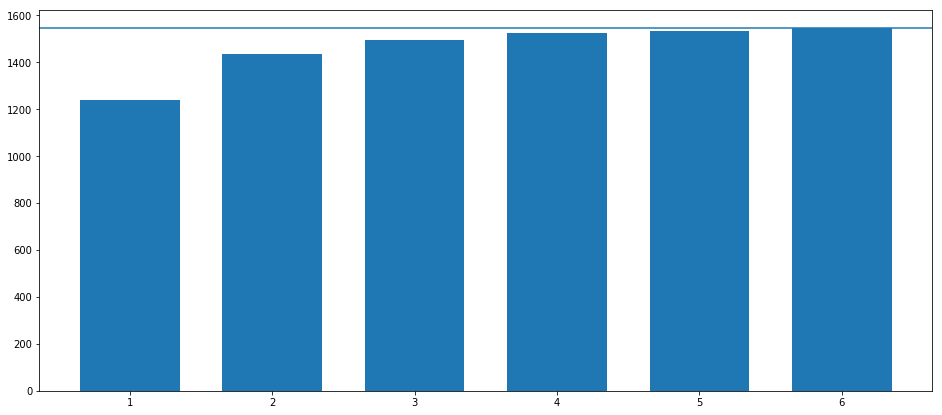

In [9]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(7)


plt.axhline(np.max(np.array(best_values)))

plt.bar(np.arange(1, len(best_values)+1), best_values, width=0.7)


plt.show()

## Data Volume

- How to get the number of loaded L1 cache lines?
- The number of L2 cache lines?


In [10]:
Kernel2DBoxStencil(stencil_range=1).genAddresses()

[('B', tidx + w*(tidy - 1) - 1),
 ('B', tidx + tidy*w - 1),
 ('B', tidx + w*(tidy + 1) - 1),
 ('B', tidx + w*(tidy - 1)),
 ('B', tidx + tidy*w),
 ('B', tidx + w*(tidy + 1)),
 ('B', tidx + w*(tidy - 1) + 1),
 ('B', tidx + tidy*w + 1),
 ('B', tidx + w*(tidy + 1) + 1)]

In [11]:
storeVolumes = []
loadVolumes = []
for r in range(1, 10):
    kernel = Kernel2DBoxStencil(stencil_range=r, l1only=True)
    
    measureMetric.measureBandwidthStart()
    block = (32, 8, 1)
    stencilbench.runKernel(kernel, kernel.getGrid(1, block, 15000, 15000), block)
    result = measureMetric.measureMetricStop()
    
    storeVolumes.append(result[1])
    loadVolumes.append(result[0])
    print("mem load: " + str(result[0] / 15000**2))
    print("mem store: " + str(result[1] / 15000**2))
    print("L2  load: " + str(result[2]*32 / 15000**2))
    print("L2  store: " + str(result[3]*32 / 15000**2))
    L2CLs, L1CLs = computeCacheVolumes(kernel, 32, block, (1,1,1))
    
    print("pred L1 CLs: " + str(L1CLs))
    print("pred L2 volume: " + str(L2CLs * 32 / block[0] / block[1] / block[2]))
    print()

mem load: 0.0003522844444444444
mem store: 0.0
L2  load: 1.0322791822222221
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512, 371513}, {375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262, 375263}, {379008, 379009, 379010, 379011, 379012, 379013, 379005, 379006, 379007}, {382755, 382756, 382757, 382758, 382759, 382760, 382761, 382762, 382763}, {386505, 386506, 386507, 386508, 386509, 386510, 386511, 386512, 386513}, {390255, 390256, 390257, 390258, 390259, 390260, 390261, 390262, 390263}, {394005, 394006, 394007, 394008, 394009, 394010, 394011, 394012, 394013}, {397760, 397761, 397762, 397763, 397755, 397756, 397757, 397758, 397759}, {375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262, 375263}, {379008, 379009, 379010, 379011, 379012, 379013, 379005, 379006, 379007}, {382755, 382756, 382757, 382758, 382759, 382760, 382761, 382762, 382763}, {386505, 386506, 386507, 386508, 386509, 386510, 386511, 38651

mem load: 0.0004123022222222222
mem store: 0.0
L2  load: 1.5202423466666666
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012, 364013}, {367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762, 367763}, {371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512, 371513}, {375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262, 375263}, {379008, 379009, 379010, 379011, 379012, 379013, 379005, 379006, 379007}, {382755, 382756, 382757, 382758, 382759, 382760, 382761, 382762, 382763}, {386505, 386506, 386507, 386508, 386509, 386510, 386511, 386512, 386513}, {390255, 390256, 390257, 390258, 390259, 390260, 390261, 390262, 390263}, {367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762, 367763}, {371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512, 371513}, {375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262, 375263}, {379008, 379009, 379010, 379011, 379012, 379013, 379005, 37900

mem load: 0.00039296
mem store: 0.0
L2  load: 1.6832504888888888
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{360256, 360257, 360258, 360259, 360260, 360261, 360262, 360255}, {364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012}, {367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762}, {371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512}, {375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262}, {379008, 379009, 379010, 379011, 379012, 379005, 379006, 379007}, {382755, 382756, 382757, 382758, 382759, 382760, 382761, 382762}, {386505, 386506, 386507, 386508, 386509, 386510, 386511, 386512}, {364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012}, {367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762}, {371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512}, {375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262}, {379008, 379009, 379010, 379011, 379012, 379005, 379006, 379007}, {382755, 382756, 382757, 3827

mem load: 0.0004805688888888889
mem store: 0.0
L2  load: 1.9643474488888888
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{356512, 356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360262, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012}, {367754, 367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762}, {371504, 371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512}, {375254, 375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262}, {379008, 379009, 379010, 379011, 379012, 379004, 379005, 379006, 379007}, {382754, 382755, 382756, 382757, 382758, 382759, 382760, 382761, 382762}, {360256, 360257, 360258, 360259, 360260, 360261, 360262, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012}, {367754, 367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762}, {371504, 371505, 371506, 371507, 371508, 371509, 371510, 37151

mem load: 0.0005067377777777778
mem store: 0.0
L2  load: 2.154191786666667
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{352754, 352755, 352756, 352757, 352758, 352759, 352760, 352761, 352762}, {356512, 356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360262, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012}, {367754, 367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762}, {371504, 371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512}, {375254, 375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262}, {379008, 379009, 379010, 379011, 379012, 379004, 379005, 379006, 379007}, {356512, 356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360262, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012}, {367754, 367755, 367756, 367757, 367758, 367759, 367760, 367761

mem load: 0.0004964977777777778
mem store: 0.0
L2  load: 2.3234082133333334
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{349004, 349005, 349006, 349007, 349008, 349009, 349010, 349011, 349012}, {352754, 352755, 352756, 352757, 352758, 352759, 352760, 352761, 352762}, {356512, 356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360262, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011, 364012}, {367754, 367755, 367756, 367757, 367758, 367759, 367760, 367761, 367762}, {371504, 371505, 371506, 371507, 371508, 371509, 371510, 371511, 371512}, {375254, 375255, 375256, 375257, 375258, 375259, 375260, 375261, 375262}, {352754, 352755, 352756, 352757, 352758, 352759, 352760, 352761, 352762}, {356512, 356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360262, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 36401

mem load: 0.0005385955555555556
mem store: 0.0
L2  load: 2.5249110755555555
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{345254, 345255, 345256, 345257, 345258, 345259, 345260, 345261}, {349004, 349005, 349006, 349007, 349008, 349009, 349010, 349011}, {352754, 352755, 352756, 352757, 352758, 352759, 352760, 352761}, {356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011}, {367754, 367755, 367756, 367757, 367758, 367759, 367760, 367761}, {371504, 371505, 371506, 371507, 371508, 371509, 371510, 371511}, {349004, 349005, 349006, 349007, 349008, 349009, 349010, 349011}, {352754, 352755, 352756, 352757, 352758, 352759, 352760, 352761}, {356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360254, 360255}, {364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011}, {367754, 367755, 3

mem load: 0.0006071466666666667
mem store: 0.0
L2  load: 4.00360832
L2  store: 2.8444444444444446e-06
pred L1 CLs: [{341504, 341505, 341506, 341507, 341508, 341509, 341510, 341511, 341503}, {345253, 345254, 345255, 345256, 345257, 345258, 345259, 345260, 345261}, {349003, 349004, 349005, 349006, 349007, 349008, 349009, 349010, 349011}, {352753, 352754, 352755, 352756, 352757, 352758, 352759, 352760, 352761}, {356503, 356504, 356505, 356506, 356507, 356508, 356509, 356510, 356511}, {360256, 360257, 360258, 360259, 360260, 360261, 360253, 360254, 360255}, {364003, 364004, 364005, 364006, 364007, 364008, 364009, 364010, 364011}, {367753, 367754, 367755, 367756, 367757, 367758, 367759, 367760, 367761}, {345253, 345254, 345255, 345256, 345257, 345258, 345259, 345260, 345261}, {349003, 349004, 349005, 349006, 349007, 349008, 349009, 349010, 349011}, {352753, 352754, 352755, 352756, 352757, 352758, 352759, 352760, 352761}, {356503, 356504, 356505, 356506, 356507, 356508, 356509, 356510, 35651

In [12]:
best_values = []

measuredValues = []
predictedValues = []

for r in range(1, 5):
    kernel = Kernel2DBoxStencil(stencil_range=r, l1only=True)
    for xblock in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        for yblock in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
            if xblock*yblock > 1024 or xblock*yblock < 32:
                continue

            block = (xblock, yblock, 1)
                        
            print(r, end=" ")
            print(block, end=" ")
            print(block[0] * block[1] * block[2], end="\n")
            stencilbench.A_gpu_aligned = int(stencilbench.A_gpu)
            stencilbench.B_gpu_aligned = int(stencilbench.B_gpu)
            measuredValues.append( stencilbench.benchKernel(kernel, 11, (xblock, yblock, 1))[2])
            predictedValues.append(predictPerformance(kernel, block, (1,1,1), 32) )

            print("{:.0f}  {:.0f}".format( measuredValues[-1], predictedValues[-1]))
            print()
    print()

1 (1, 32, 1) 32
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120   533  2304   288     0     0  7957
 5120   200    72    72     0     0  5392
141  189

1 (1, 64, 1) 64
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120  1067  2304   576     0     0  8491
 5120   200    72    72     0     0  5392
140  377

1 (1, 128, 1) 128
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 2560  1067  1152   576     0     0  4779
 2560   200  1848    72     0     0  4608
140  442

1 (1, 256, 1) 256
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280  1067   576   576     0     0  2923
 1280   200  3128    72     0     0  4608
140  442

1 (1, 512, 1) 512
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640  1067   288   576     0     0  2283
  640   200  3768    72     0     0  4608
138  442

1 (1, 1024, 1) 1024
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   144   576     0     0  1963
  320   200  4088    7

19.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067    39   576     0     0  1963
  320   200   728    72     0     0  1248
1135  1631

1 (1024, 1, 1) 1024
19.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067    39   576     0     0  1963
  320   200   728    72     0     0  1248
1163  1631


2 (1, 32, 1) 32
200.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120   533  6400   800     0     0 12053
 5120   200  1080   200     0     0  6400
144  442

2 (1, 64, 1) 64
200.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120  1067  6400  1600     0     0 12587
 5120   200  7480   200     0     0 12800
143  442

2 (1, 128, 1) 128
200.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 2560  1067  3200  1600     0     0  6827
 2560   200 10040   200     0     0 12800
143  442

2 (1, 256, 1) 256
200.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280  1067  1600  1600     0     0  3947
 1280   200 11320   200     0  

55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640  1067   220  1600     0     0  3307
  640   200  2680   200     0     0  3520
1394  1606

2 (256, 4, 1) 1024
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   110  1600     0     0  2987
  320   200  3000   200     0     0  3520
1415  1606

2 (512, 1, 1) 512
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640  1067   220  1600     0     0  3307
  640   200  2680   200     0     0  3520
1343  1606

2 (512, 2, 1) 1024
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   110  1600     0     0  2987
  320   200  3000   200     0     0  3520
1371  1606

2 (1024, 1, 1) 1024
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   110  1600     0     0  2987
  320   200  3000   200     0     0  3520
1355  1606


3 (1, 32, 1) 32
392.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120   533 12544  1568     0     0 18197
 5120   200  7224   392 

108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640  1067   434  3136     0     0  4843
  640   200  6104   392     0     0  6944
1486  1595

3 (128, 8, 1) 1024
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   217  3136     0     0  4523
  320   200  6424   392     0     0  6944
1488  1595

3 (256, 1, 1) 256
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280  1067   868  3136     0     0  5483
 1280   200  5464   392     0     0  6944
1464  1595

3 (256, 2, 1) 512
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640  1067   434  3136     0     0  4843
  640   200  6104   392     0     0  6944
1473  1595

3 (256, 4, 1) 1024
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   217  3136     0     0  4523
  320   200  6424   392     0     0  6944
1482  1595

3 (512, 1, 1) 512
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640  1067   434  3136     0     0  4843
  640   200  6104   

175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   351  5184     0     0  6571
  320   200 10712   648     0     0 11232
1522  1631

4 (128, 1, 1) 128
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 2560  1067  2808  5184     0     0  8811
 2560   200  8472   648     0     0 11232
1515  1631

4 (128, 2, 1) 256
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280  1067  1404  5184     0     0  7531
 1280   200  9752   648     0     0 11232
1515  1631

4 (128, 4, 1) 512
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640  1067   702  5184     0     0  6891
  640   200 10392   648     0     0 11232
1515  1631

4 (128, 8, 1) 1024
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320  1067   351  5184     0     0  6571
  320   200 10712   648     0     0 11232
1516  1631

4 (256, 1, 1) 256
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280  1067  1404  5184     0     0  7531
 1280   200  9752   6

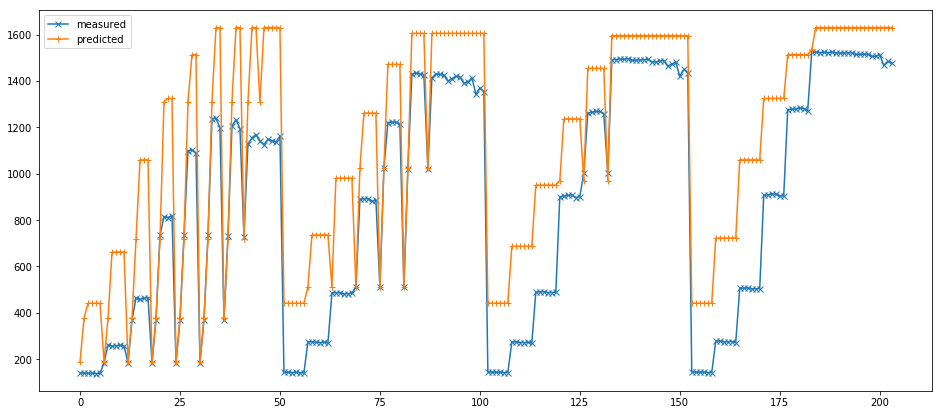

In [13]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(7)


ax.plot(measuredValues, "-x", label="measured")
ax.plot(predictedValues, "-+", label="predicted")
#ax.set_yscale("log")
ax.legend()

plt.show()


In [14]:
def busyFactor(p):
    return max(1, p)
    #return 1 + (log( 1 + exp((p-1)  )))

def predictPerformance(kernel, block, grid, registers):

    threadsPerBlock = block[0]*block[1]*block[2]
    blocksPerSM = min( 32, int(2**16 / (threadsPerBlock * max(registers, 32)) ))
    warpsPerSM = blocksPerSM * ((threadsPerBlock-1) // 32 + 1)
    warpsPerBlock = ceil(threadsPerBlock / 32)
    
    SMcount = 80 
    clock = 1.38    
    cl_size = 32
    blockShedRate = 0.46
    L2CLs, L1CLs = computeCacheVolumes(kernel, cl_size, block, grid)

    L2CLs += threadsPerBlock / 4
    L1LoadCycles = sum([ len(ld) for ld in L1CLs ]) / 4   / warpsPerBlock
    print(L1LoadCycles)

    # Iitial values
    #Tint = 40 * 5 * max(1, warpsPerSM / 12)
    Tint = 0
    TL1thru = (L1LoadCycles * blocksPerSM) 
    TDP  = kernel.flops * max(1, (warpsPerSM / 8))  * 8
    Tlat_mem = (max(250,  (warpsPerSM*32*16 * SMcount ) / 780 * clock ) if kernel.bytes > 0 else 0)
    Tlat_L2 = (max(200,  (L2CLs * blocksPerSM * SMcount * cl_size ) / 2000 * clock ) if kernel.bytes > 0 else 0)
    Tblocksched = SMcount / 0.5  * blocksPerSM  
    Ttotal = Tblocksched + Tint + max(TDP, TL1thru) + Tlat_mem + Tlat_L2
    print("Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal")
    print("{:5.0f} {:5.0f} {:5.0f} {:5.0f} {:5.0f} {:5.0f} {:5.0f}".format(Tblocksched, Tint, TL1thru, TDP, Tlat_mem, Tlat_L2, Ttotal ))
    
    delta = 100
    for i in range(0, 200):
        Tint = 0 #40 * 5 * busyFactor(Tint / Ttotal * warpsPerSM / 12)
        TL1thru = L1LoadCycles  * busyFactor(TL1thru / Ttotal * warpsPerSM)
        TDP  = kernel.flops * busyFactor(warpsPerSM * (TDP / Ttotal) / 8)  * 8 
        Tlat_mem = max(271, Tlat_mem / Ttotal  * (warpsPerSM*32*16 * SMcount ) / 780 * clock) if kernel.bytes > 0 else 0 
        Tlat_L2 = (max(200,  Tlat_L2 / Ttotal  * (L2CLs * blocksPerSM * SMcount * cl_size ) / 2000 * clock ) if kernel.bytes > 0 else 0)
        new_Ttotal = Tblocksched + Tint + max(TDP,  TL1thru) + Tlat_mem + Tlat_L2
        delta = abs(new_Ttotal - Ttotal)
        Ttotal = new_Ttotal
        
        if i > 100 and delta < 0.01:
            break
    
    print("{:5.0f} {:5.0f} {:5.0f} {:5.0f} {:5.0f} {:5.0f} {:5.0f}".format(Tblocksched, Tint, TL1thru, TDP, Tlat_mem, Tlat_L2, Ttotal ))
    return kernel.flops * blocksPerSM * threadsPerBlock * (clock * SMcount / Ttotal )


$$T_{L1thru} = C_{L1loads}  F_{busy}( \frac{T_{L1thru}N_{warps} }{ T_{total}})$$
$$T_{DP} = 8I_{Flops}  F_{busy}( \frac{T_{DP}N_{warps} }{ 8\quad T_{total}})$$
$$T_{lat}^{mem} = \max(271,  \frac{T_{lat}^{mem}}{T_{total}} DV_{mem} / 780 * clock) $$
$$T_{lat}^{L2} = \max(200,  \frac{T_{lat}^{L2}}{T_{total}} * DV_{L2} / 2000 * clock) $$

$$T_{total} = T{blocksched} + T_{int} + max(T_{DP}, T_{L1thru}) + T_{lat}^{mem} + T_{lat}^{L2}$$


In [20]:
best_values = []

measuredValues = []
predictedValues = []

for r in range(1, 5):
    kernel = Kernel2DBoxStencil(stencil_range=r)
    
    for xblock in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        for yblock in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
            if xblock*yblock > 1024 or xblock*yblock < 32:
                continue

            block = (xblock, yblock, 1)
                        
            print(r, end=" ")
            print(block, end=" ")
            print(block[0] * block[1] * block[2], end="\n")
            stencilbench.A_gpu_aligned = int(stencilbench.A_gpu)
            stencilbench.B_gpu_aligned = int(stencilbench.B_gpu)
            measuredValues.append( stencilbench.benchKernel(kernel, 11, (xblock, yblock, 1))[2])
            predictedValues.append(predictPerformance(kernel, block, (1,1,1), 32) )

            print("{:.0f}  {:.0f}".format( measuredValues[-1], predictedValues[-1]))
            print()
    print()

1 (1, 32, 1) 32
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120     0  2304   288  2319  4296 14039
 5120   200    72    72   271   200  5863
98  174

1 (1, 64, 1) 64
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120     0  2304   576  4638  8366 20428
 5120   200    72    72   271  2703  8366
101  243

1 (1, 128, 1) 128
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 2560     0  1152   576  4638  8253 16603
 2560   200    72    72   271  5150  8253
97  247

1 (1, 256, 1) 256
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280     0   576   576  4638  8196 14690
 1280   200    72    72   271  6373  8196
87  248

1 (1, 512, 1) 512
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0   288   576  4638  8168 14022
  640   200    72    72   271  6985  8168
56  249

1 (1, 1024, 1) 1024
72.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   144   576  4638  8154 13688
  320   200    72    72   

19.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0    78   576  4638  3660  9514
  640   200    20    72  3526   200  4638
435  439

1 (512, 2, 1) 1024
19.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0    39   576  4638  2741  8275
  320   200    20    72  3846   200  4638
435  439

1 (1024, 1, 1) 1024
19.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0    39   576  4638  3639  9173
  320   200    20    72  3846   200  4638
429  439


2 (1, 32, 1) 32
200.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120     0  6400   800  2319  4522 18361
 5120   200   609   200   271   200  6400
124  442

2 (1, 64, 1) 64
200.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 5120     0  6400  1600  4638  8592 24750
 5120   200  7009   200   271   200 12800
123  442

2 (1, 128, 1) 128
200.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 2560     0  3200  1600  4638  8366 18764
 2560   200  9569   200   271   200

55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280     0   440  1600  4638  5568 13086
 1280   200    55   200   271  3617  5568
963  1015

2 (256, 2, 1) 512
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0   220  1600  4638  3702 10580
  640   200    55   200  3398   200  4638
962  1219

2 (256, 4, 1) 1024
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   110  1600  4638  2770  9328
  320   200    55   200  3718   200  4638
980  1219

2 (512, 1, 1) 512
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0   220  1600  4638  5497 12375
  640   200    55   200   271  4186  5497
945  1028

2 (512, 2, 1) 1024
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   110  1600  4638  3660 10218
  320   200    55   200  3718   200  4638
956  1219

2 (1024, 1, 1) 1024
55.0
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   110  1600  4638  5462 12020
  320   200    55   200   271

108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280     0   868  3136  4638  4748 13802
 1280   200  4993   392   271   200  6944
1181  1595

3 (128, 4, 1) 512
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0   434  3136  4638  3307 11721
  640   200  5633   392   271   200  6944
1237  1595

3 (128, 8, 1) 1024
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   217  3136  4638  2586 10680
  320   200  5953   392   271   200  6944
1248  1595

3 (256, 1, 1) 256
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280     0   868  3136  4638  7433 16487
 1280   200   108   392   271  5290  7433
1175  1490

3 (256, 2, 1) 512
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0   434  3136  4638  4635 13049
  640   200  5633   392   271   200  6944
1198  1595

3 (256, 4, 1) 1024
108.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   217  3136  4638  3236 11330
  320   200  5953   

175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0   702  5184  4638  2939 13401
  640   200  9921   648   271   200 11232
1372  1631

4 (64, 16, 1) 1024
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   351  5184  4638  2431 12572
  320   200 10241   648   271   200 11232
1360  1631

4 (128, 1, 1) 128
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 2560     0  2808  5184  4638  9553 21935
 2560   200  8001   648   271   200 11232
1310  1631

4 (128, 2, 1) 256
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
 1280     0  1404  5184  4638  5709 16811
 1280   200  9281   648   271   200 11232
1321  1631

4 (128, 4, 1) 512
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  640     0   702  5184  4638  3787 14249
  640   200  9921   648   271   200 11232
1358  1631

4 (128, 8, 1) 1024
175.5
Tblocksched Tint TL1thru TDP Tlat_mem, Tlat_L2, Ttotal
  320     0   351  5184  4638  2826 12968
  320   200 10241   

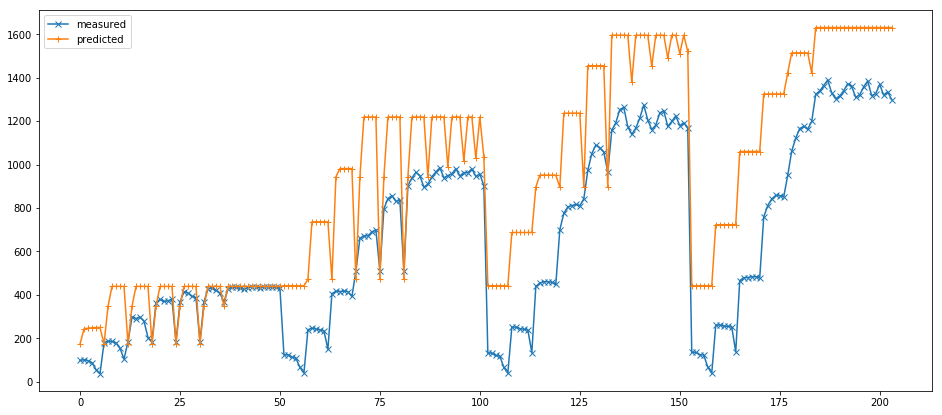

In [21]:
fig, ax = plt.subplots()
fig.set_figwidth(16)
fig.set_figheight(7)


ax.plot(measuredValues, "-x", label="measured")
ax.plot(predictedValues, "-+", label="predicted")
#ax.set_yscale("log")
ax.legend()

plt.show()


In [19]:
print(Kernel2DBoxStencil(stencil_range=r).text)

void __global__  Kernel2DStencil (double* A, double* B, int w, int h) {
  int x = (threadIdx.x + blockIdx.x * blockDim.x);
  int y = (threadIdx.y + blockIdx.y * blockDim.y);
  if( x < 4 || x >= w - 4 || y < 4 || y >= h-4) return;
  double sum = (
                B[(y + -4) * w + x + -4] + 
                B[(y + -4) * w + x + -3] + 
                B[(y + -4) * w + x + -2] + 
                B[(y + -4) * w + x + -1] + 
                B[(y + -4) * w + x + 0] + 
                B[(y + -4) * w + x + 1] + 
                B[(y + -4) * w + x + 2] + 
                B[(y + -4) * w + x + 3] + 
                B[(y + -4) * w + x + 4] + 
                B[(y + -3) * w + x + -4] + 
                B[(y + -3) * w + x + -3] + 
                B[(y + -3) * w + x + -2] + 
                B[(y + -3) * w + x + -1] + 
                B[(y + -3) * w + x + 0] + 
                B[(y + -3) * w + x + 1] + 
                B[(y + -3) * w + x + 2] + 
                B[(y + -3) * w + x + 3] + 
              